# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Total words in the corpus: 1161192


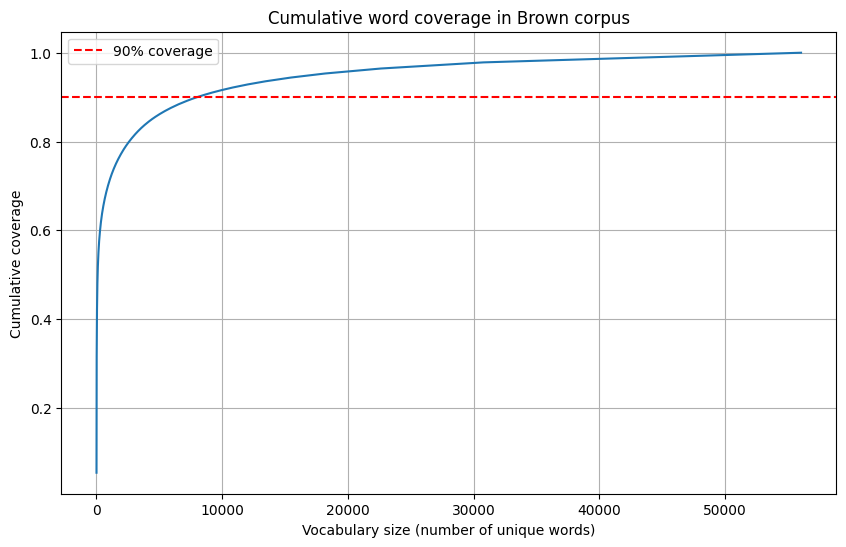

Minimum vocabulary size for 90% coverage: 8012 words
Coverage at this size: 90.00%


In [6]:

import nltk
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Download Brown corpus
nltk.download('brown')
from nltk.corpus import brown

# Get all the words in the corpus (tokens)
words = brown.words()
print(f"Total words in the corpus: {len(words)}")

# Counter(words) creates a dictionary where each word is associated with its frequency of occurrence.
#Then, all unique words are sorted in descending frequency order, from the most frequent to the least frequent.
freq = Counter(words)
sorted_words = sorted(freq.items(), key=lambda x: x[1], reverse=True)
total_words = sum(freq.values())  # total number of occurrences (sum of frequencies)
unique_words = len(freq)

# Calculating cumulative coverage
#Coverage coverage = cum / total_words shows the proportion of all corpus words that are in the top-i.
cumulative = []
cum = 0
for i, (word, count) in enumerate(sorted_words, start=1):
    cum += count
    coverage = cum / total_words
    cumulative.append((i, coverage))

# Extract x (dictionary size) and y (coverage) for the graph
vocab_sizes = [x[0] for x in cumulative]
coverages = [x[1] for x in cumulative]

# Plotting the graph
plt.figure(figsize=(10,6))
plt.plot(vocab_sizes, coverages)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% coverage')
plt.xlabel('Vocabulary size (number of unique words)')
plt.ylabel('Cumulative coverage')
plt.title('Cumulative word coverage in Brown corpus')
plt.legend()
plt.grid(True)
plt.show()

# Find the minimum vocabulary size that achieves coverage >= 90%
target_vocab_size = next(i for i, cov in cumulative if cov >= 0.9)
print(f"Minimum vocabulary size for 90% coverage: {target_vocab_size} words")
print(f"Coverage at this size: {cumulative[target_vocab_size-1][1]:.2%}")


##Answer


We loaded the Brown corpus, counted the frequencies of all words, and sorted them in descending order. Then, we calculated the cumulative coverage, which is the percentage of all occurrences covered by the top
k
k most frequent words. The graph shows that the curve increases rapidly at the beginning and then slows down. The minimum
k
k value that achieves a coverage of 90% is 8012. This means that the top 8012 most frequent words cover 90% of all word occurrences in the corpus.

###Why the coverage slows down the increase as the vocabulary size increases?

The slowdown in coverage growth is due to the fact that in any language, there is a small set of very frequent words — such as articles, prepositions, and conjunctions — that are much more common than others. These words account for the majority of all word occurrences, and in the Brown corpus, the top 8,012 most frequent words account for 90% of text coverage. As we add words that are less frequent, their contribution to the overall coverage decreases. As a result, thousands of rare words (specialized terms, outdated vocabulary) bring only a tiny increase, because they are literally found only a few times. Since the total coverage cannot exceed 100%, after the bulk of words have already been accounted for, the remaining rare words share only a small remainder. Therefore, the coverage curve sharply rises at the beginning, and then smoothly approaches the maximum, slowing down with each step.

###Which empirical law explains the slowing down increase of the coverage?

In any language, there is a small set of words that are used particularly frequently, such as prepositions, conjunctions, and pronouns. These words cover a large portion of any text, resulting in a steep increase in coverage from the beginning. As we add more frequent words to the dictionary, they become less common and contribute less to the overall coverage. As we progress down the list, the words become rarer, and each new addition contributes only a fraction of a percentage point. As a result, the increase in coverage gradually slows down, and the curve gradually approaches 100%.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [7]:


from collections import defaultdict, Counter
import re

class BPETokenizer:
    """
    Byte-Pair Encoding (BPE) tokenizer.

    Attributes:
    vocab_size (int): the final size of the vocabulary (including basic characters and pairs).
    merges (dict): a dictionary where the key is a pair (tuple) of merged tokens, and the value is a new token.
    vocab (set): the set of all tokens (basic + merged).
    """
    def __init__(self, vocab_size: int):
        self.vocab_size = vocab_size
        self.merges = {}
        self.vocab = set()

    def train(self, corpus: list, verbose: bool = False):
        """
        Trains BPE on a list of strings (corpus).

        Args:
        corpus: a list of strings (sentences).
        verbose: if True, print progress.
        """
        # For each word: split into characters, add the word end marker </w>, and calculate the frequency of this sequence in the corpus.
        word_counts = Counter()
        for sentence in corpus:
            words = sentence.split()
            for w in words:
                # Convert a word into a list of characters + special end character </w>
                tokenized = list(w) + ['</w>']
                word_counts[tuple(tokenized)] += 1

        # Formation of an initial vocabulary consisting of all unique characters,
        chars = set()
        for word_tokens in word_counts:
            for ch in word_tokens:
                chars.add(ch)
        self.vocab = set(chars)

        # In the next step, we take a frequent pair of adjacent tokens, merge them into a new token, and update the entire body.
        num_merges = self.vocab_size - len(self.vocab)  # how many pairs need to be added
        if num_merges <= 0:
            print("The specified dictionary size is less than or equal to the number of basic characters. No training is required.")
            return

        for merge_idx in range(num_merges):
            # Counting the frequencies of all pairs in all words
            pair_counts = defaultdict(int)
            for word_tokens, freq in word_counts.items():
                for i in range(len(word_tokens)-1):
                    pair = (word_tokens[i], word_tokens[i+1])
                    pair_counts[pair] += freq

            if not pair_counts:
                break

            # Finding the most frequent pair
            best_pair = max(pair_counts, key=pair_counts.get)
            best_count = pair_counts[best_pair]

            # Creating a new token
            new_token = best_pair[0] + best_pair[1]
            self.merges[best_pair] = new_token
            self.vocab.add(new_token)

            if verbose:
                print(f"Шаг {merge_idx+1}: объединяем {best_pair} -> {new_token} (частота {best_count})")

           # Update all words: replace the pair with a new token
            new_word_counts = Counter()
            for word_tokens, freq in word_counts.items():
                new_tokens = []
                i = 0
                while i < len(word_tokens):
                    if i < len(word_tokens)-1 and (word_tokens[i], word_tokens[i+1]) == best_pair:
                        new_tokens.append(new_token)
                        i += 2
                    else:
                        new_tokens.append(word_tokens[i])
                        i += 1
                new_word_counts[tuple(new_tokens)] += freq
            word_counts = new_word_counts

    def tokenize(self, text: str) -> list:
        """
        Tokenizes text using trained unions.

        Args:
        text: a string to tokenize.

        Returns:
        a list of tokens.
        """
        # The code splits the text into words, turns each word into a list of characters with the end marker </w>, and sequentially applies
        #the learned merging rules, combining characters into subwords as long as possible.
        words = text.split()
        tokens = []
        for w in words:
            # Splitting a word into characters + end of the word
            word = list(w) + ['</w>']
            # Apply all merge operations in the learning order
            while True:
                # Finding the first applicable pair
                best_pair = None
                for i in range(len(word)-1):
                    pair = (word[i], word[i+1])
                    if pair in self.merges:
                        best_pair = pair
                        break
                if best_pair is None:
                    break
                # Combining
                new_word = []
                i = 0
                while i < len(word):
                    if i < len(word)-1 and (word[i], word[i+1]) == best_pair:
                        new_word.append(self.merges[best_pair])
                        i += 2
                    else:
                        new_word.append(word[i])
                        i += 1
                word = new_word
            tokens.extend(word[:-1])  # remove the </w> at the end of each word
        return tokens


## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [8]:

import random
import numpy as np

# Use Brown corpus sentences as a list of strings
sentences = [' '.join(sent) for sent in brown.sents()]
print(f"Total sentences: {len(sentences)}")

# Train the tokenizer with the selected vocabulary size
vocab_size = target_vocab_size  # from Task 1
tokenizer = BPETokenizer(vocab_size=vocab_size)
print(f"Training BPE with vocabulary size {vocab_size}...")
tokenizer.train(sentences, verbose=False)
print("Training completed.")

# Take 1000 random sentences for statistics calculation
sample_sentences = random.sample(sentences, min(1000, len(sentences)))

fertility_values = []
length_values = []

for sent in sample_sentences:
    tokens = tokenizer.tokenize(sent)
    fertility = len(tokens) / len(sent.split())  # number of tokens per word
    fertility_values.append(fertility)
    length_values.append(len(tokens))

mean_fertility = np.mean(fertility_values)
std_fertility = np.std(fertility_values)
mean_length = np.mean(length_values)
std_length = np.std(length_values)

print(f"\nAnalysis on 1000 sentences:")
print(f"Average fertility (tokens per word): {mean_fertility:.3f} ± {std_fertility:.3f}")
print(f"Average tokenized sentence length: {mean_length:.1f} ± {std_length:.1f} tokens")

Total sentences: 57340
Training BPE with vocabulary size 8012...
Training completed.

Analysis on 1000 sentences:
Average fertility (tokens per word): 1.467 ± 0.495
Average tokenized sentence length: 30.4 ± 21.6 tokens


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later.

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.